In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import json
%cd /content/drive/My\ Drive/Colab\ Notebooks


/content/drive/My Drive/Colab Notebooks


In [3]:
        basedir = "./LRCN_dataset1"
        print(os.path.isdir(basedir))
        all_metadata_filenames = []
        all_video_filenames = []
        for dirpath, _, filenames in os.walk(basedir):
            for filename in filenames:
                if filename.endswith(".json"):
                    all_metadata_filenames.append(os.path.join(dirpath, filename).replace("\\","/"))
                elif filename.endswith(".jpg"):
                    all_video_filenames.append(os.path.join(dirpath, filename).replace("\\","/"))      

True


In [4]:
        metadata = {}
        for cur_metadata_filename in all_metadata_filenames:
            with open(cur_metadata_filename) as f_in:
                cur_metadata = json.load(f_in)
                for cur_key in cur_metadata:
                    # Store expanded versions of paths of videos in metadata
                    full_filename = os.path.join(os.path.dirname(cur_metadata_filename), cur_key.replace('.mp4','.jpg')).replace("\\","/")
                    metadata[full_filename] = {'label': cur_metadata[cur_key]['label']}
                    if 'original' in cur_metadata[cur_key] and cur_metadata[cur_key]['original']:
                        full_orig_filename = os.path.join(os.path.dirname(cur_metadata_filename), cur_metadata[cur_key]['original'].replace('.mp4','.jpg')).replace("\\","/")
                        metadata[full_filename]['original'] = full_orig_filename

In [5]:
        real_videos = []
        fake_videos = []
        for cur_video_filename in all_video_filenames:
            if metadata[cur_video_filename]['label'] == "FAKE":
                fake_videos.append(cur_video_filename)
            elif metadata[cur_video_filename]['label'] == "REAL":
                real_videos.append(cur_video_filename)
        # Sort the pathnames since consecutive runs of os.walk aren't guaranteed
        # to return all the data in the same order
        real_videos.sort()
        fake_videos.sort()

In [6]:
import cv2
import glob
import random
paths,Y=[],[]
fake=random.sample(fake_videos,len(real_videos))
#real_videos=real_videos[:1200]
#fake=fake[:2400]
for x in real_videos:
    paths.append(x)
    Y.append(0)
for x in fake:
    paths.append(x)
    Y.append(1)

In [7]:
def shuffle(X,y):
    new_train=[]
    for m,n in zip(X,y):
        new_train.append([m,n])
    random.shuffle(new_train)
    X,y=[],[]
    for x in new_train:
        X.append(x[0])
        y.append(x[1])
    return X,y

In [8]:
paths,y=shuffle(paths,Y)

In [9]:
def get_birghtness(img):
    return img/img.max()

In [10]:
from PIL import Image 
def process_img(img):
    imgs=[]
    
    for x in range(10):
        imgs.append(get_birghtness(img[:,x*299:(x+1)*299,:]))
    return np.array(imgs)

In [11]:

def gets(paths):
    al=[]
    for x in paths:
        img=cv2.cvtColor(cv2.imread(x),cv2.COLOR_BGR2RGB)
        img=cv2.resize(img,(2990,299))
        al.append(process_img(img))
    return al
def generator(paths,y,batch_size=16):
    
    while True:
        for x in range(len(paths)//batch_size):
            if x*batch_size+batch_size>len(paths):
                yield np.array(gets(paths[x*batch_size:])),np.array(y[x*batch_size:])
            yield np.array(gets(paths[x*batch_size:x*batch_size+batch_size])),np.array(y[x*batch_size:x*batch_size+batch_size])

In [12]:
from keras.layers import Activation
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv3D, MaxPooling3D, ZeroPadding3D
from keras.layers import Input

# from schedules import onetenth_4_8_12
import numpy as np
import cv2
import os
import random
import time
import argparse
import matplotlib.pyplot as plt
from os.path import join
from os import listdir
from random import shuffle


In [13]:
def cnn_model(model_name, img_size, weights):
    """
    Model definition using Xception net architecture
    """
    input_size = (img_size, img_size, 3)
    if model_name == "xception":
        baseModel = Xception(
            weights="imagenet",
            include_top=False,
            input_shape=(img_size, img_size, 3)
        )
    elif model_name == "iv3":
        baseModel = InceptionV3(
            weights="imagenet",
            include_top=False,
            input_shape=(img_size, img_size, 3)
        )
    elif model_name == "irv2":
        baseModel = InceptionResNetV2(
            weights="imagenet",
            include_top=False,
            input_shape=(img_size, img_size, 3)
        )
    elif model_name == "resnet":
        baseModel = ResNet50(
            weights="imagenet",
            include_top=False,
            input_shape=(img_size, img_size, 3)
        )
    elif model_name == "nasnet":
        baseModel = NASNetLarge(
            weights="imagenet",
            include_top=False,
            input_shape=(img_size, img_size, 3)
        )
    elif model_name == "ef0":
        baseModel = EfficientNetB0(
            input_size,
            weights="imagenet",
            include_top=False
        )
    elif model_name == "ef5":
        baseModel = EfficientNetB5(
            input_size,
            weights="imagenet",
            include_top=False
        )

    headModel = baseModel.output
    headModel = GlobalAveragePooling2D()(headModel)
    headModel = Dense(
        512,
        activation="relu",
        kernel_initializer="he_uniform",
        name="fc1")(
        headModel
    )
    headModel = Dropout(0.4)(headModel)
    predictions = Dense(
        2,
        activation="softmax",
        kernel_initializer="he_uniform")(
        headModel
    )
    model = Model(inputs=baseModel.input, outputs=predictions)

    model.load_weights(weights)
    print("Weights loaded...")
    model_lstm = Model(
        inputs=baseModel.input,
        outputs=model.get_layer("fc1").output
    )

    for layer in baseModel.layers:
        layer.trainable = True

    optimizer = Nadam(
        lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004
    )
    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )
    return model_lstm


def lstm_model(shape):
    # Model definition
    main_input = Input(
        shape=(shape[0],
               shape[1]),
        name="main_input"
    )
    headModel = Bidirectional(LSTM(256, return_sequences=True))(main_input)
    #headModel = LSTM(32)(main_input)
    headModel = TemporalMaxPooling()(headModel)
    # headModel = TimeDistributed(Dense(512))(headModel)
    # # headModel = Bidirectional(LSTM(512, dropout=0.2))(main_input)
    # headModel = LSTM(256)(headModel)
    predictions = Dense(1,activation='sigmoid')(headModel)
    model = Model(inputs=main_input, outputs=predictions)

    # Model compilation
    # opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / EPOCHS)
    optimizer = Nadam(
        lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004
    )
    

    return model
import tensorflow as tf
from keras import backend as K

from keras.engine import InputSpec
from keras.engine.topology import Layer
import numpy as np
from keras import utils

import matplotlib.pyplot as plt
class TemporalMaxPooling(Layer):
    """
    This pooling layer accepts the temporal sequence output by a recurrent layer
    and performs temporal pooling, looking at only the non-masked portion of the sequence.
    The pooling layer converts the entire variable-length hidden vector sequence
    into a single hidden vector.
    Modified from https://github.com/fchollet/keras/issues/2151 so code also
    works on tensorflow backend. Updated syntax to match Keras 2.0 spec.
    Args:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        3D tensor with shape: `(samples, steps, features)`.
        input shape: (nb_samples, nb_timesteps, nb_features)
        output shape: (nb_samples, nb_features)
    Examples:
        > x = Bidirectional(GRU(128, return_sequences=True))(x)
        > x = TemporalMaxPooling()(x)
    """

    def __init__(self, **kwargs):
        super(TemporalMaxPooling, self).__init__(**kwargs)
        self.supports_masking = True
        self.input_spec = InputSpec(ndim=3)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[2])

    def call(self, x, mask=None):
        if mask is None:
            mask = K.sum(K.ones_like(x), axis=-1)

        # if masked, set to large negative value so we ignore it
        # when taking max of the sequence
        # K.switch with tensorflow backend is less useful than Theano's
        if K.backend() != "theano":
            mask = K.expand_dims(mask, axis=-1)
            mask = K.tile(mask, (1, 1, K.int_shape(x)[2]))
            masked_data = tf.where(
                K.equal(mask, K.zeros_like(mask)), K.ones_like(x) * -np.inf, x
            )  # if masked assume value is -inf
            return K.max(masked_data, axis=1)
        else:  # theano backend
            mask = mask.dimshuffle(0, 1, "x")
            masked_data = K.switch(K.eq(mask, 0), -np.inf, x)
            return masked_data.max(axis=1)

    def compute_mask(self, input, mask):
        # do not pass the mask to the next layers
        return None

In [14]:


from tensorflow.keras.applications.xception import decode_predictions
%matplotlib inline


xcep=tf.keras.applications.xception.Xception(weights='imagenet',include_top=True)
from keras.layers import *
inp=Input((10,299,299,3))
x=TimeDistributed(xcep)(inp)
x = Bidirectional(LSTM(256, return_sequences=True))(x)
x = TemporalMaxPooling()(x)
x = Dense(1,activation='sigmoid')(x)



91889664/91884032 [==============================] - 1s 0us/step


In [15]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def precision_fake(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives +K.epsilon())
        return precision
def recall_fake(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(1.0*y_true, 0, 1)))
        recall = true_positives / (possible_positives +K.epsilon())
        return recall   
def precision_real(y_true, y_pred):
        true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
        predicted_negatives = K.sum(K.round(K.clip((1-y_pred), 0, 1)))
        precision = true_negatives / (predicted_negatives+K.epsilon() )
        return precision
def recall_real(y_true, y_pred):
        true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
        possible_negatives = K.sum(K.round(K.clip(1.0-y_true, 0, 1)))
        recall = true_negatives / (possible_negatives + K.epsilon())
        return recall                
def F1_fake(y_true, y_pred):
  precision = precision_fake(y_true, y_pred)
  recall = recall_fake(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))   
def F1_real(y_true, y_pred):
  precision = precision_real(y_true, y_pred)
  recall = recall_real(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))   



In [16]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
X_train, X_test, y_train, y_test=train_test_split(paths,y,test_size=0.25)

In [17]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def schedule(epoch):
    return [6e-4,1e-4][epoch]
callback=LearningRateScheduler(schedule)

In [18]:
from keras.models import Sequential, load_model
filepath = "bidirectional_lstm.h5"
new_model = load_model(filepath,custom_objects={"TemporalMaxPooling":TemporalMaxPooling,"f1":f1,"precision_fake":precision_fake,"recall_fake":recall_fake,"precision_real":precision_real,"recall_real":recall_real,"F1_fake":F1_fake,"F1_real":F1_real})

In [19]:
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
stopping = EarlyStopping(monitor="val_loss", patience=2, verbose=0)


In [20]:
history = new_model.fit(generator(X_train,y_train,4),steps_per_epoch=len(X_train)//4+1,validation_data=generator(X_test,y_test,4),validation_steps=len(X_test)//4+1,epochs=3,callbacks=[checkpoint, stopping])

Epoch 1/3
727/727 [==============================] - ETA: 0s - loss: 0.2563 - accuracy: 0.9003 - f1: 0.8380 - precision_real: 0.8432 - precision_fake: 0.8633 - recall_real: 0.8563 - recall_fake: 0.8478 - F1_real: 0.8338 - F1_fake: 0.8380
Epoch 00001: loss improved from inf to 0.25630, saving model to bidirectional_lstm.h5
727/727 [==============================] - 1610s 2s/step - loss: 0.2563 - accuracy: 0.9003 - f1: 0.8380 - precision_real: 0.8432 - precision_fake: 0.8633 - recall_real: 0.8563 - recall_fake: 0.8478 - F1_real: 0.8338 - F1_fake: 0.8380 - val_loss: 0.2382 - val_accuracy: 0.8940 - val_f1: 0.8499 - val_precision_real: 0.8693 - val_precision_fake: 0.8234 - val_recall_real: 0.7850 - val_recall_fake: 0.9136 - val_F1_real: 0.8112 - val_F1_fake: 0.8499
Epoch 2/3
727/727 [==============================] - ETA: 0s - loss: 0.1863 - accuracy: 0.9237 - f1: 0.8578 - precision_real: 0.8759 - precision_fake: 0.8673 - recall_real: 0.8657 - recall_fake: 0.8739 - F1_real: 0.8573 - F1_fake

In [22]:
import pickle
with open('/trainHistoryDict_2', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

dict_keys(['loss', 'accuracy', 'f1', 'precision_real', 'precision_fake', 'recall_real', 'recall_fake', 'F1_real', 'F1_fake', 'val_loss', 'val_accuracy', 'val_f1', 'val_precision_real', 'val_precision_fake', 'val_recall_real', 'val_recall_fake', 'val_F1_real', 'val_F1_fake'])


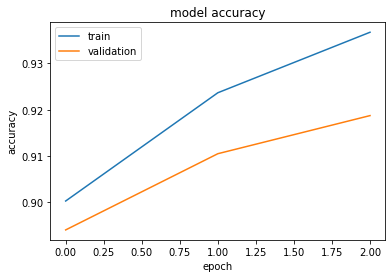

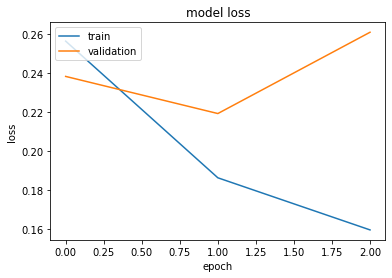

In [23]:
print(history.history.keys())
#  "Accuracy"
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

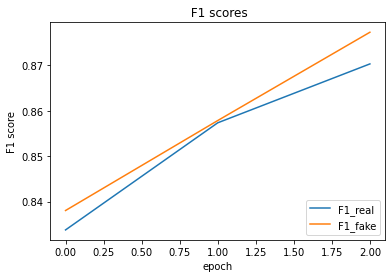

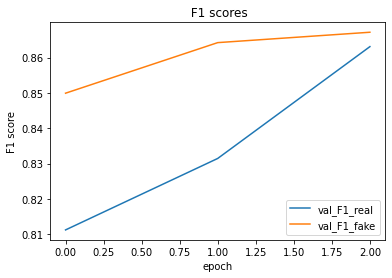

In [24]:
import matplotlib.pyplot as plt


plt.plot(history.history['F1_real'])
plt.plot(history.history['F1_fake'])

plt.title(' F1 scores')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend([ 'F1_real','F1_fake'], loc='lower right')
plt.show()
# "Loss"


plt.plot(history.history['val_F1_real'])
plt.plot(history.history['val_F1_fake'])
plt.title(' F1 scores')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend([ 'val_F1_real','val_F1_fake'], loc='lower right')
plt.show()

dict_keys(['loss', 'accuracy', 'f1', 'precision_real', 'precision_fake', 'recall_real', 'recall_fake', 'F1_real', 'F1_fake', 'val_loss', 'val_accuracy', 'val_f1', 'val_precision_real', 'val_precision_fake', 'val_recall_real', 'val_recall_fake', 'val_F1_real', 'val_F1_fake'])


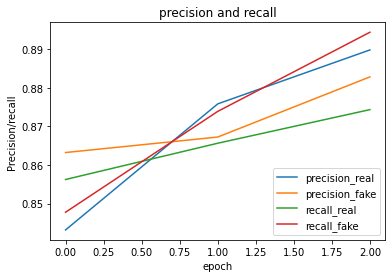

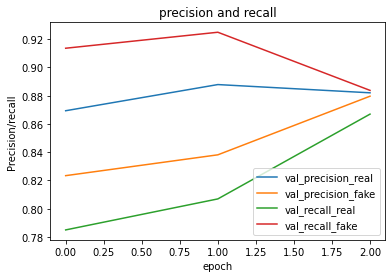

In [25]:
print(history.history.keys())
#  "Accuracy"
import matplotlib.pyplot as plt


plt.plot(history.history['precision_real'])
plt.plot(history.history['precision_fake'])
plt.plot(history.history['recall_real'])
plt.plot(history.history['recall_fake'])

plt.title('precision and recall')
plt.ylabel('Precision/recall')
plt.xlabel('epoch')
plt.legend(['precision_real','precision_fake','recall_real','recall_fake'], loc='lower right')
plt.show()
# "Loss"


plt.plot(history.history['val_precision_real'])
plt.plot(history.history['val_precision_fake'])
plt.plot(history.history['val_recall_real'])
plt.plot(history.history['val_recall_fake'])

plt.title('precision and recall')
plt.ylabel('Precision/recall')
plt.xlabel('epoch')
plt.legend(['val_precision_real','val_precision_fake','val_recall_real','val_recall_fake'], loc='lower right')
plt.show()

dict_keys(['loss', 'accuracy', 'f1', 'precision_real', 'precision_fake', 'recall_real', 'recall_fake', 'F1_real', 'F1_fake', 'val_loss', 'val_accuracy', 'val_f1', 'val_precision_real', 'val_precision_fake', 'val_recall_real', 'val_recall_fake', 'val_F1_real', 'val_F1_fake'])


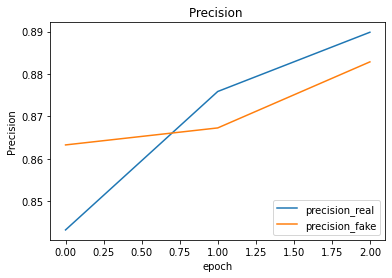

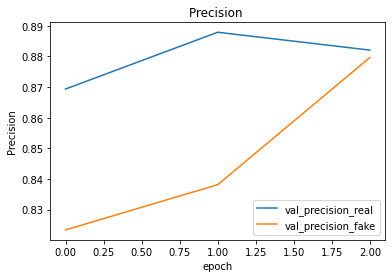

In [26]:
print(history.history.keys())
#  "Accuracy"
import matplotlib.pyplot as plt


plt.plot(history.history['precision_real'])
plt.plot(history.history['precision_fake'])


plt.title('Precision ')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['precision_real','precision_fake'], loc='lower right')
plt.show()
# "Loss"


plt.plot(history.history['val_precision_real'])
plt.plot(history.history['val_precision_fake'])


plt.title('Precision ')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['val_precision_real','val_precision_fake'], loc='lower right')
plt.show()

dict_keys(['loss', 'accuracy', 'f1', 'precision_real', 'precision_fake', 'recall_real', 'recall_fake', 'F1_real', 'F1_fake', 'val_loss', 'val_accuracy', 'val_f1', 'val_precision_real', 'val_precision_fake', 'val_recall_real', 'val_recall_fake', 'val_F1_real', 'val_F1_fake'])


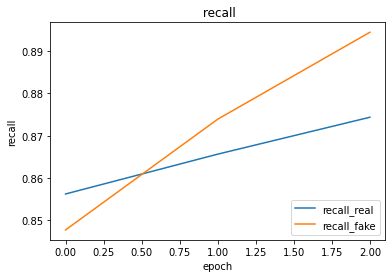

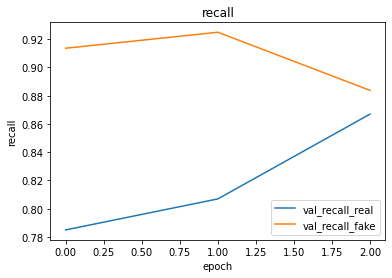

In [27]:
print(history.history.keys())
#  "Accuracy"
import matplotlib.pyplot as plt



plt.plot(history.history['recall_real'])
plt.plot(history.history['recall_fake'])

plt.title(' recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['recall_real','recall_fake'], loc='lower right')
plt.show()
# "Loss"



plt.plot(history.history['val_recall_real'])
plt.plot(history.history['val_recall_fake'])

plt.title('recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['val_recall_real','val_recall_fake'], loc='lower right')
plt.show()

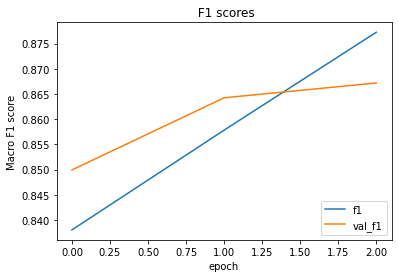

In [28]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title(' F1 scores')
plt.ylabel('Macro F1 score')
plt.xlabel('epoch')
plt.legend(['f1','val_f1'], loc='lower right')
plt.show()

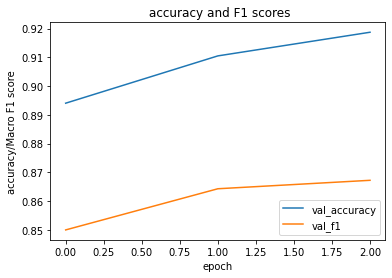

In [29]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_f1'])

plt.title(' accuracy and F1 scores')
plt.ylabel('accuracy/Macro F1 score')
plt.xlabel('epoch')
plt.legend(['val_accuracy','val_f1'], loc='lower right')
plt.show()

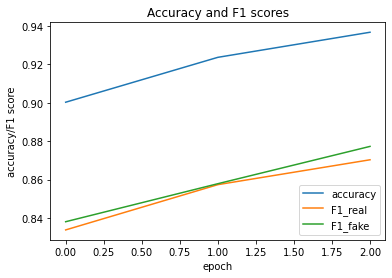

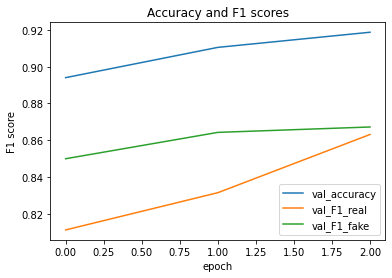

In [30]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['F1_real'])
plt.plot(history.history['F1_fake'])

plt.title('Accuracy and F1 scores')
plt.ylabel('accuracy/F1 score')
plt.xlabel('epoch')
plt.legend(['accuracy', 'F1_real','F1_fake'], loc='lower right')
plt.show()
# "Loss"
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_F1_real'])
plt.plot(history.history['val_F1_fake'])
plt.title('Accuracy and F1 scores')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['val_accuracy', 'val_F1_real','val_F1_fake'], loc='lower right')
plt.show()